In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train/test split and cross‐validation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    KFold
)

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import (
    LinearRegression,
    ElasticNet,
    ElasticNetCV
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor
)

# Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score

# Statistical modeling / detailed summary
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Optional: suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("add.age.of.car.csv")
df.head(6)

,year of prodaction,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
5,2000,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,M5,X,9.3,6.8,8.2,34,189


In [3]:
# הצגת ראש גיליון הנתונים
df = df.iloc[ :, 1:]
print(df.head())

   Vehicle Age   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0           22  ACURA    1.6EL       COMPACT          1.6          4   
1           22  ACURA    1.6EL       COMPACT          1.6          4   
2           22  ACURA    3.2TL      MID-SIZE          3.2          6   
3           22  ACURA    3.5RL      MID-SIZE          3.5          6   
4           22  ACURA  INTEGRA    SUBCOMPACT          1.8          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
0           A4    X               9.2             6.7              8.1   
1           M5    X               8.5             6.5              7.6   
2          AS5    Z              12.2             7.4             10.0   
3           A4    Z              13.4             9.2             11.5   
4           A4    X              10.0             7.0              8.6   

   COMB (mpg)  EMISSIONS  
0          35        186  
1          37        175  
2          28        230  
3          25 

In [4]:

# הדפסת כמות התצפיות וכמות המשתנים
num_rows, num_columns = df.shape
print(f"Number of observations: {num_rows}")
print(f"Number of variables: {num_columns}")

Number of observations: 22556
Number of variables: 13


In [5]:
# בדיקה האם כל התצפיות מלאות (ללא ערכים חסרים)
missing_values = df.isnull().sum().sum()
if missing_values == 0:
    print("All observations are complete (no missing values).")
else:
    print(f"Warning: There are {missing_values} missing values in the dataset.")

All observations are complete (no missing values).


#The above cell we know that there are no missing values in the original DataFrame


In [6]:
# Display data types for each column in an organized way
print("Data Types for Each Column:")
df.dtypes

Data Types for Each Column:


Vehicle Age           int64
MAKE                 object
MODEL                object
VEHICLE CLASS        object
ENGINE SIZE         float64
CYLINDERS             int64
TRANSMISSION         object
FUEL                 object
FUEL CONSUMPTION    float64
HWY (L/100 km)      float64
COMB (L/100 km)     float64
COMB (mpg)            int64
EMISSIONS             int64
dtype: object

In [7]:
# בחירת עמודות מספריות ללא 'CYLINDERS'
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns = numerical_columns.drop('CYLINDERS', errors='ignore')

numerical_columns

Index(['Vehicle Age', 'ENGINE SIZE', 'FUEL CONSUMPTION', 'HWY (L/100 km)',
       'COMB (L/100 km)', 'COMB (mpg)', 'EMISSIONS'],
      dtype='object')

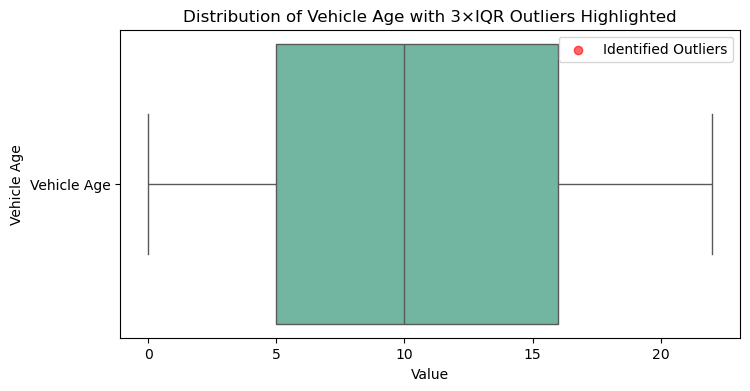

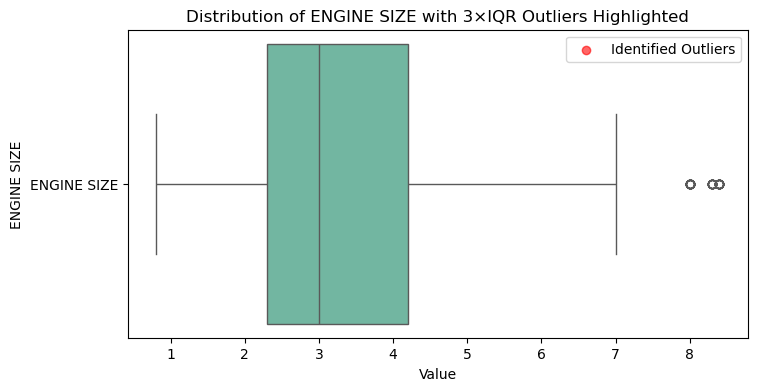

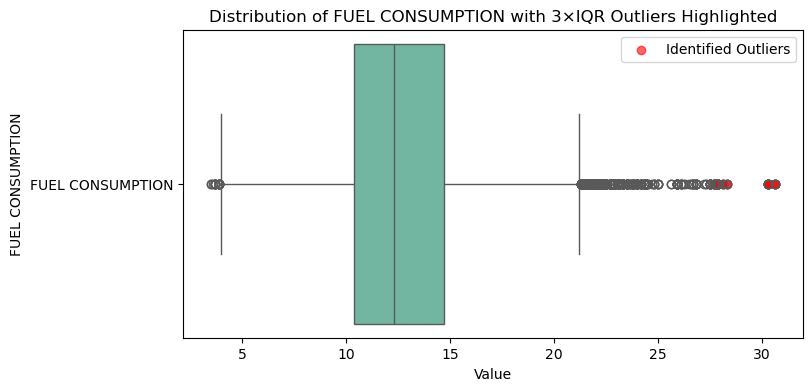

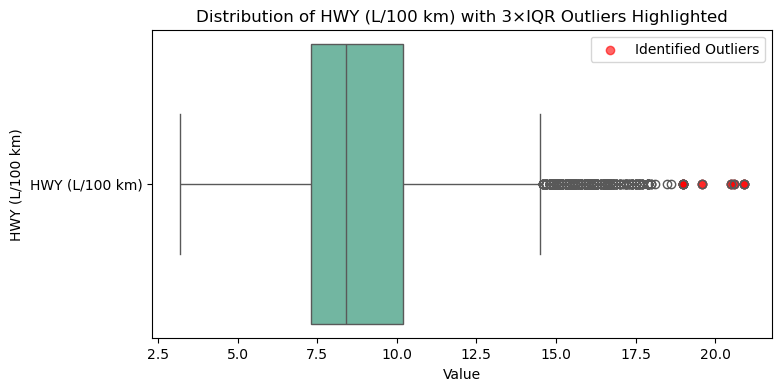

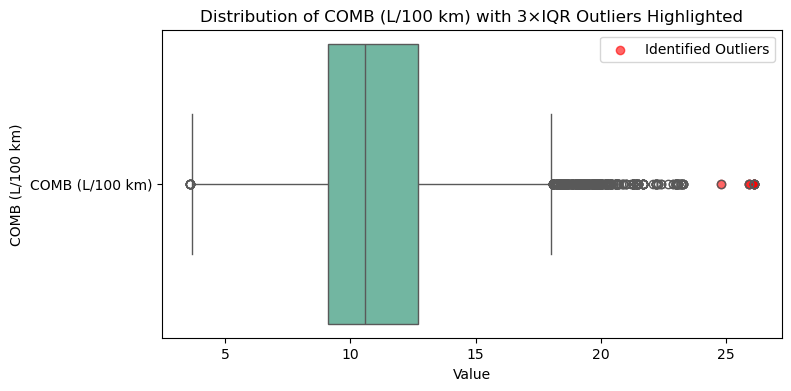

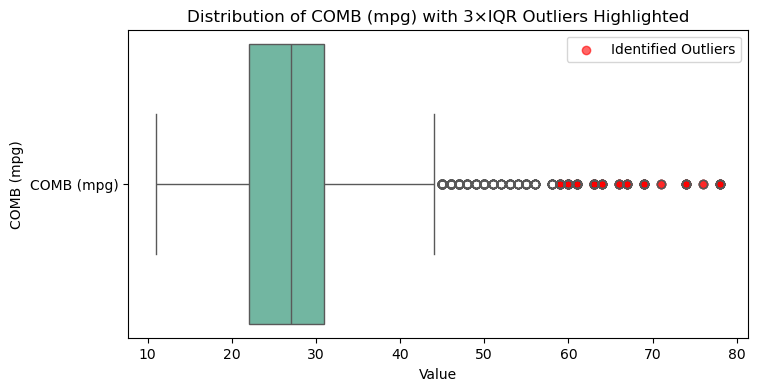

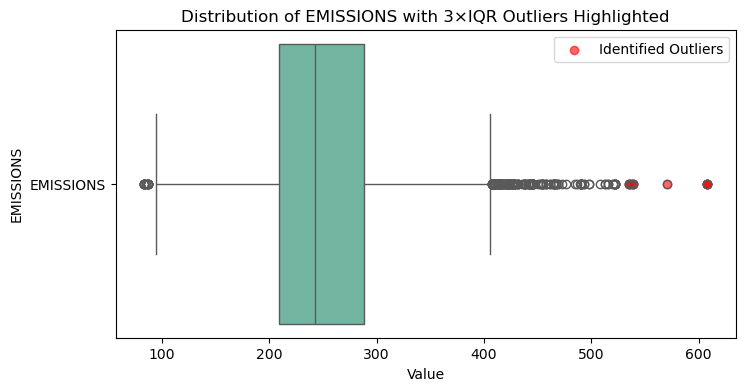

Number of observations before cleaning: 22556
Number of observations after cleaning: 22419
Number of removed observations: 137


In [8]:
# זיהוי חריגים לפי 3×IQR מבלי להסיר אותם
outliers_mask = pd.Series(False, index=df.index)

# יצירת Boxplot נפרד לכל משתנה עם סימון ערכים שנופלים תחת ההגדרה של 3×IQR
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # זיהוי ערכים שנופלים תחת ההגדרה של 3×IQR אך לא מוסרים בפועל
    col_outliers_mask = (df[col] < (Q1 - 3.0 * IQR)) | (df[col] > (Q3 + 3.0 * IQR))
    col_outliers_indices = df.index[col_outliers_mask]

    # יצירת Boxplot עבור המשתנה
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df[[col]], orient="h", palette="Set2")

    # סימון הערכים החריגים בנקודות אדומות בתוך ה-Boxplot
    plt.scatter(df.loc[col_outliers_indices, col], [0] * len(col_outliers_indices),
                color='red', alpha=0.6, label="Identified Outliers")

    plt.title(f"Distribution of {col} with 3×IQR Outliers Highlighted")
    plt.xlabel("Value")
    plt.ylabel(col)
    plt.legend()
    plt.show()

# **הסרת החריגים** מכל השורות בהן קיים לפחות ערך חריג אחד
outliers_mask = pd.Series(False, index=df.index)

for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # זיהוי ערכים חריגים
    col_outliers_mask = (df[col] < (Q1 - 3.0 * IQR)) | (df[col] > (Q3 + 3.0 * IQR))
    outliers_mask |= col_outliers_mask  # שילוב המסכות לכל העמודות

df_clean = df[~outliers_mask]  # יצירת DataFrame נקי מהחריגים

# **הדפסת מספר התצפיות לפני ואחרי**
original_observations = df.shape[0]
cleaned_observations = df_clean.shape[0]

print(f"Number of observations before cleaning: {original_observations}")
print(f"Number of observations after cleaning: {cleaned_observations}")
print(f"Number of removed observations: {original_observations - cleaned_observations}")

In [9]:
# Display descriptive statistics
print("\nDescriptive Statistical Measures:")
print(df.describe())


Descriptive Statistical Measures:
        Vehicle Age   ENGINE SIZE     CYLINDERS  FUEL CONSUMPTION  \
count  22556.000000  22556.000000  22556.000000      22556.000000   
mean      10.445558      3.356646      5.854141         12.763513   
std        6.298269      1.335425      1.819597          3.500999   
min        0.000000      0.800000      2.000000          3.500000   
25%        5.000000      2.300000      4.000000         10.400000   
50%       10.000000      3.000000      6.000000         12.300000   
75%       16.000000      4.200000      8.000000         14.725000   
max       22.000000      8.400000     16.000000         30.600000   

       HWY (L/100 km)  COMB (L/100 km)    COMB (mpg)     EMISSIONS  
count    22556.000000     22556.000000  22556.000000  22556.000000  
mean         8.919126        11.034341     27.374534    250.068452  
std          2.274764         2.910920      7.376982     59.355276  
min          3.200000         3.600000     11.000000     83.000000 

In [10]:
# Display frequency tables for categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nFrequency Table for {col}:")
    print(df[col].value_counts())



Frequency Table for MAKE:
MAKE
CHEVROLET        1725
BMW              1490
GMC              1357
FORD             1276
MERCEDES-BENZ     935
                 ... 
ALFA ROMEO          8
SRT                 4
GENESIS             4
BUGATTI             3
PLYMOUTH            2
Name: count, Length: 87, dtype: int64

Frequency Table for MODEL:
MODEL
JETTA          89
MUSTANG        88
RANGER         61
SENTRA         58
ALTIMA         57
               ..
Optima FE       1
ARNAGE RL       1
BROOKLANDS      1
335d SEDAN      1
XC60 B6 AWD     1
Name: count, Length: 4242, dtype: int64

Frequency Table for VEHICLE CLASS:
VEHICLE CLASS
SUV                         2640
COMPACT                     2636
MID-SIZE                    2300
PICKUP TRUCK - STANDARD     1689
SUBCOMPACT                  1559
FULL-SIZE                   1086
TWO-SEATER                   999
SUV: Small                   929
SUV - SMALL                  827
MINICOMPACT                  783
STATION WAGON - SMALL        737
Mid

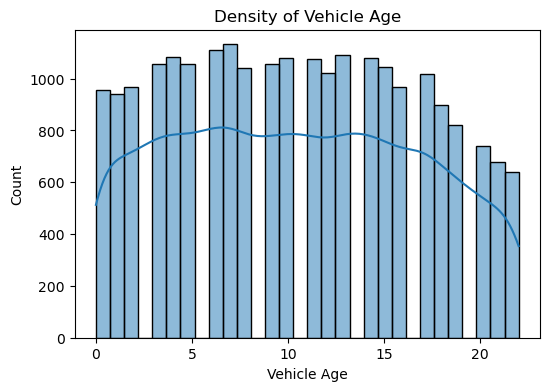

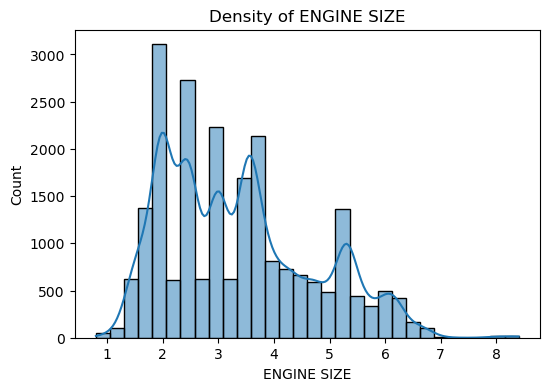

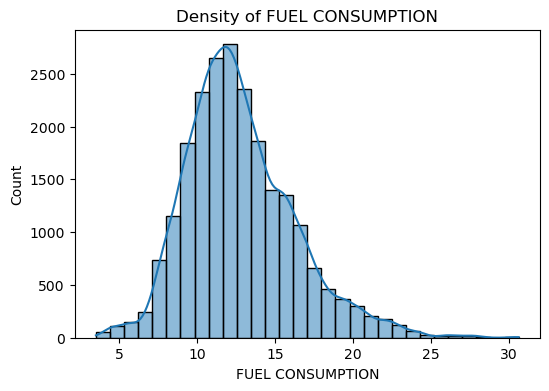

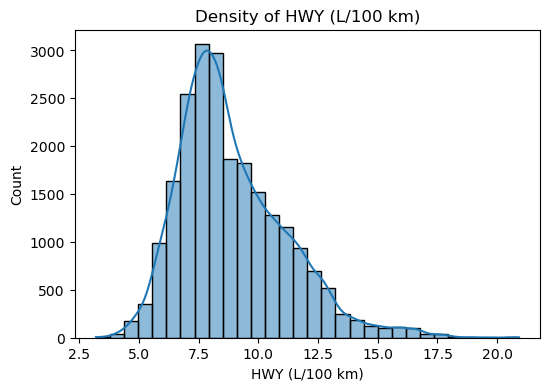

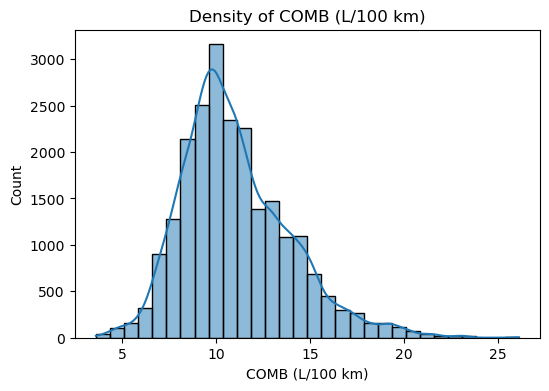

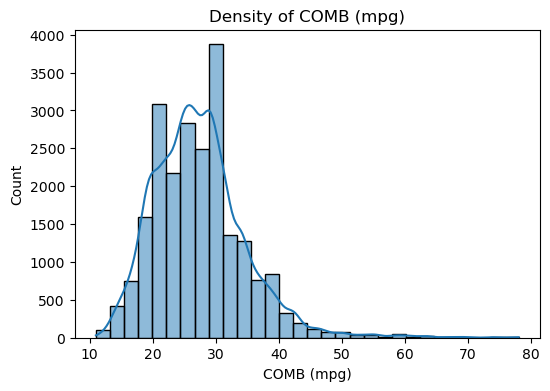

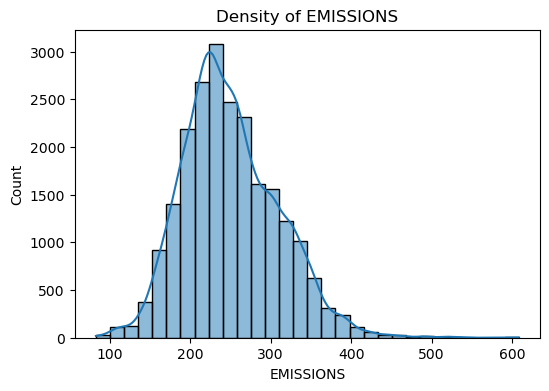

In [11]:
for col in numerical_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Density of {col}')
    plt.show()

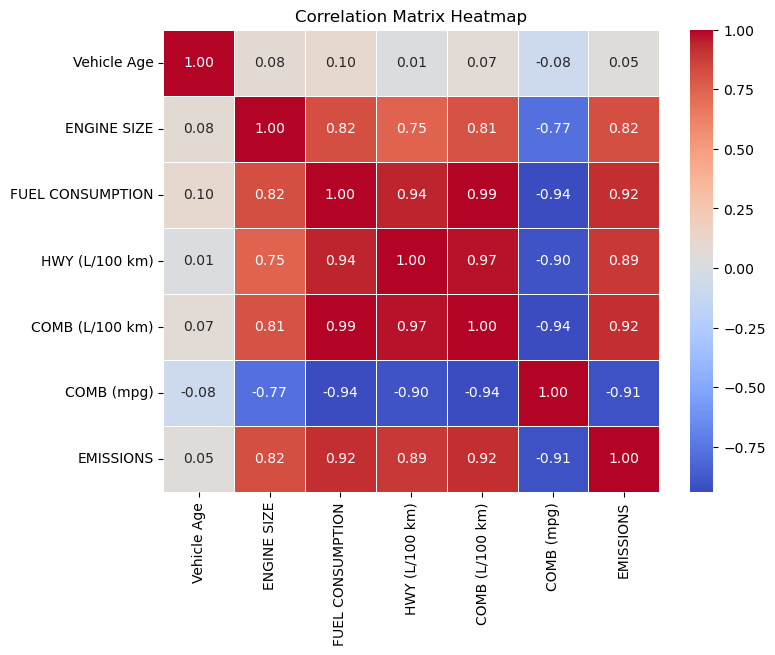

   Vehicle Age   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0           22  ACURA    1.6EL       COMPACT          1.6          4   
1           22  ACURA    1.6EL       COMPACT          1.6          4   
2           22  ACURA    3.2TL      MID-SIZE          3.2          6   
3           22  ACURA    3.5RL      MID-SIZE          3.5          6   
4           22  ACURA  INTEGRA    SUBCOMPACT          1.8          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
0           A4    X               9.2             6.7              8.1   
1           M5    X               8.5             6.5              7.6   
2          AS5    Z              12.2             7.4             10.0   
3           A4    Z              13.4             9.2             11.5   
4           A4    X              10.0             7.0              8.6   

   COMB (mpg)  EMISSIONS  
0          35        186  
1          37        175  
2          28        230  
3          25 

In [12]:
# חישוב מטריצת הקורלציות עבור המשתנים הכמותיים
correlation_matrix = df_clean[numerical_columns].corr()

# יצירת מפת חום להצגת מטריצת הקורלציות
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)

# כותרת
plt.title("Correlation Matrix Heatmap")

# הצגת הגרף
plt.show()
print(df.head())

In [13]:
# הבטחה שהנתונים קיימים
if 'df_clean' not in locals():
    raise NameError("The dataset 'df_clean' is not defined.")

In [14]:
# סינון רק למשתנים מספריים ואיכותיים
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
categorical_columns = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()


In [15]:
# הבטחה שכל הנתונים המספריים הם באמת מספריים
for col in numerical_columns:
  df_clean.loc[:, col] = pd.to_numeric(df_clean[col], errors='coerce')

In [16]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [17]:
# הסרת עמודות עם ערכים חסרים רבים מדי
df_clean = df_clean.dropna(axis=1, thresh=int(0.8 * len(df_clean)))
print(df.head())

   Vehicle Age   MAKE    MODEL VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
0           22  ACURA    1.6EL       COMPACT          1.6          4   
1           22  ACURA    1.6EL       COMPACT          1.6          4   
2           22  ACURA    3.2TL      MID-SIZE          3.2          6   
3           22  ACURA    3.5RL      MID-SIZE          3.5          6   
4           22  ACURA  INTEGRA    SUBCOMPACT          1.8          4   

  TRANSMISSION FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
0           A4    X               9.2             6.7              8.1   
1           M5    X               8.5             6.5              7.6   
2          AS5    Z              12.2             7.4             10.0   
3           A4    Z              13.4             9.2             11.5   
4           A4    X              10.0             7.0              8.6   

   COMB (mpg)  EMISSIONS  
0          35        186  
1          37        175  
2          28        230  
3          25 

In [18]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [19]:
# חישוב מטריצת הקורלציות מחדש
correlation_matrix = df_clean[numerical_columns].corr()


In [20]:
# מציאת זוגות עם מתאם גבוה מ-0.9
high_corr_pairs = set()
for i in range(len(numerical_columns)):
    for j in range(i + 1, len(numerical_columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.add((numerical_columns[i], numerical_columns[j]))


In [21]:
# רשימת משתנים להסרה
variables_to_remove = set()
for var1, var2 in high_corr_pairs:
    if var1 in df_clean.columns and var2 in df_clean.columns:
        if df_clean[var1].isnull().sum() > df_clean[var2].isnull().sum():
            variables_to_remove.add(var1)
        else:
            variables_to_remove.add(var2)


In [22]:
# הסרת המשתנים שנבחרו
print(f"Removing highly correlated variables: {variables_to_remove}")
df_clean = df_clean.drop(columns=variables_to_remove, errors='ignore')

Removing highly correlated variables: {'COMB (L/100 km)', 'CYLINDERS', 'COMB (mpg)', 'HWY (L/100 km)', 'EMISSIONS'}


In [23]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,FUEL CONSUMPTION
0,22,ACURA,1.6EL,COMPACT,1.6,A4,X,9.2
1,22,ACURA,1.6EL,COMPACT,1.6,M5,X,8.5
2,22,ACURA,3.2TL,MID-SIZE,3.2,AS5,Z,12.2
3,22,ACURA,3.5RL,MID-SIZE,3.5,A4,Z,13.4
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,A4,X,10.0
...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,AS8,Z,10.7
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,AS8,Z,10.5
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,AS8,Z,11.0
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,AS8,Z,11.5


In [24]:
df

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [25]:
# עדכון רשימת המשתנים המספריים לאחר הסרת משתנים
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()


In [26]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,FUEL CONSUMPTION
0,22,ACURA,1.6EL,COMPACT,1.6,A4,X,9.2
1,22,ACURA,1.6EL,COMPACT,1.6,M5,X,8.5
2,22,ACURA,3.2TL,MID-SIZE,3.2,AS5,Z,12.2
3,22,ACURA,3.5RL,MID-SIZE,3.5,A4,Z,13.4
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,A4,X,10.0
...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,AS8,Z,10.7
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,AS8,Z,10.5
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,AS8,Z,11.0
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,AS8,Z,11.5


In [27]:
# יצירת עמודות אינטראקציה - מכפלה בין עמודות מספריות לעמודות איכותיות
for cat_col in categorical_columns:
    if cat_col in df_clean.columns:
        cat_codes = df_clean[cat_col].astype('category').cat.codes
        for num_col in numerical_columns:
            if num_col in df_clean.columns:
                df_clean[f"{num_col}_x_{cat_col}"] = df_clean[num_col] * cat_codes


In [28]:
# עדכון רשימת המשתנים המספריים לאחר יצירת אינטראקציות
numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()


In [29]:
df_clean = df_clean.dropna(subset=['FUEL CONSUMPTION'])

In [30]:
df_clean

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,FUEL CONSUMPTION,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,...,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
0,22,ACURA,1.6EL,COMPACT,1.6,A4,X,9.2,0,0.0,...,9.2,0,0.0,0.0,44,3.2,18.4,66,4.8,27.6
1,22,ACURA,1.6EL,COMPACT,1.6,M5,X,8.5,0,0.0,...,8.5,0,0.0,0.0,594,43.2,229.5,66,4.8,25.5
2,22,ACURA,3.2TL,MID-SIZE,3.2,AS5,Z,12.2,0,0.0,...,744.2,88,12.8,48.8,330,48.0,183.0,88,12.8,48.8
3,22,ACURA,3.5RL,MID-SIZE,3.5,A4,Z,13.4,0,0.0,...,830.8,88,14.0,53.6,44,7.0,26.8,88,14.0,53.6
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,A4,X,10.0,0,0.0,...,21560.0,374,30.6,170.0,44,3.6,20.0,66,5.4,30.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,AS8,Z,10.7,0,172.0,...,43153.1,0,42.0,224.7,0,36.0,192.6,0,8.0,42.8
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,AS8,Z,10.5,0,172.0,...,42409.5,0,42.0,220.5,0,36.0,189.0,0,8.0,42.0
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,AS8,Z,11.0,0,172.0,...,44440.0,0,42.0,231.0,0,36.0,198.0,0,8.0,44.0
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,AS8,Z,11.5,0,172.0,...,46690.0,0,44.0,253.0,0,36.0,207.0,0,8.0,46.0


In [31]:
# חלוקת הנתונים ל-Train ו-Test (80%-20%)
train_data, test_data = train_test_split(df_clean, test_size=0.2, random_state=42)


In [32]:
df

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,22,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,22,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,22,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,22,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,22,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22551,0,Volvo,XC40 T5 AWD,SUV: Small,2.0,4,AS8,Z,10.7,7.7,9.4,30,219
22552,0,Volvo,XC60 B5 AWD,SUV: Small,2.0,4,AS8,Z,10.5,8.1,9.4,30,219
22553,0,Volvo,XC60 B6 AWD,SUV: Small,2.0,4,AS8,Z,11.0,8.7,9.9,29,232
22554,0,Volvo,XC90 T5 AWD,SUV: Standard,2.0,4,AS8,Z,11.5,8.4,10.1,28,236


In [33]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['EMISSIONS'], errors='ignore')  # מוודא שהעמודה התלויה מוסרת
y = df['EMISSIONS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X_train.shape)
print(y_train.shape)

(18044, 12)
(18044,)


In [35]:
print(X_train.shape)  # מספר השורות והעמודות לפני הסינון

(18044, 12)


In [36]:
print(X_train.dtypes)

Vehicle Age           int64
MAKE                 object
MODEL                object
VEHICLE CLASS        object
ENGINE SIZE         float64
CYLINDERS             int64
TRANSMISSION         object
FUEL                 object
FUEL CONSUMPTION    float64
HWY (L/100 km)      float64
COMB (L/100 km)     float64
COMB (mpg)            int64
dtype: object


In [37]:
X_train.isna().any().any()

False

In [38]:
X_train

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,TRANSMISSION,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg)
2777,19,TOYOTA,CAMRY SOLARA CONVERTIBLE,SUBCOMPACT,3.0,6,A4,X,12.5,8.4,10.7,26
8081,13,CHEVROLET,EXPRESS CARGO CONV AWD,VAN - CARGO,5.3,8,A4,X,16.5,12.2,14.6,19
553,22,TOYOTA,CELICA,SUBCOMPACT,1.8,4,M5,X,8.7,6.6,7.8,36
20711,1,Audi,S5 Sportback quattro,Mid-size,3.0,6,AS8,Z,11.5,8.5,10.1,28
15914,6,HYUNDAI,ELANTRA GT,MID-SIZE,2.0,4,M6,X,9.8,7.1,8.6,33
...,...,...,...,...,...,...,...,...,...,...,...,...
11964,10,PORSCHE,911 TARGA 4S,MINICOMPACT,3.8,6,M6,Z,11.9,8.1,10.2,28
21575,1,Volkswagen,Atlas Cross Sport 4MOTION,SUV: Small,2.0,4,AS8,X,11.7,10.0,10.9,26
5390,16,MAZDA,MAZDA5 WAGON,STATION WAGON - MID-SIZE,2.3,4,M5,X,10.6,8.0,9.4,30
860,21,DODGE,RAM 2500 VAN,VAN - CARGO,3.9,6,A3,X,17.1,13.2,15.3,18


In [39]:
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

In [40]:
print(X_train.isnull().sum())

Vehicle Age             0
MAKE                18044
MODEL               17991
VEHICLE CLASS       18044
ENGINE SIZE             0
CYLINDERS               0
TRANSMISSION        18044
FUEL                18044
FUEL CONSUMPTION        0
HWY (L/100 km)          0
COMB (L/100 km)         0
COMB (mpg)              0
dtype: int64


In [41]:
print(X_train)

       Vehicle Age  MAKE  MODEL  VEHICLE CLASS  ENGINE SIZE  CYLINDERS  \
2777            19   NaN    NaN            NaN          3.0          6   
8081            13   NaN    NaN            NaN          5.3          8   
553             22   NaN    NaN            NaN          1.8          4   
20711            1   NaN    NaN            NaN          3.0          6   
15914            6   NaN    NaN            NaN          2.0          4   
...            ...   ...    ...            ...          ...        ...   
11964           10   NaN    NaN            NaN          3.8          6   
21575            1   NaN    NaN            NaN          2.0          4   
5390            16   NaN    NaN            NaN          2.3          4   
860             21   NaN    NaN            NaN          3.9          6   
15795            6   NaN    NaN            NaN          2.0          4   

       TRANSMISSION  FUEL  FUEL CONSUMPTION  HWY (L/100 km)  COMB (L/100 km)  \
2777            NaN   NaN      

In [42]:
X_train = X_train.dropna(axis=1, how='all')
X_train = X_train.drop(columns=['MODEL'], errors='ignore')

print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [43]:
X_train = sm.add_constant(X_train)  # הוספת קבוע
model = sm.OLS(y_train, X_train).fit()
print(model.summary())  # בדיקה שהמודל עובד

                            OLS Regression Results                            
Dep. Variable:              EMISSIONS   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                 2.136e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:14:21   Log-Likelihood:                -79215.
No. Observations:               18044   AIC:                         1.584e+05
Df Residuals:                   18036   BIC:                         1.585e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              188.3278      2.786  

In [44]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)  # הוספת קבוע למודל
model = sm.OLS(y_train, X_train).fit()  # הרצת המודל

In [45]:
# הגדרת משתנה המטרה (תלוי) והמשתנים הבלתי תלויים
TARGET_COLUMN = 'FUEL CONSUMPTION'  # עדכון שם העמודה כדי להתאים לזמינות
if TARGET_COLUMN in train_data.columns:
    X_train = train_data.drop(columns=[TARGET_COLUMN], errors='ignore')
    y_train = train_data[TARGET_COLUMN]
    X_test = test_data.drop(columns=[TARGET_COLUMN], errors='ignore')
    y_test = test_data[TARGET_COLUMN]
else:
    raise KeyError(f"The target column '{TARGET_COLUMN}' was not found in the dataset. Available columns: {train_data.columns.tolist()}")


In [46]:
print(train_data.columns)
print(X_train.shape, y_train.shape)

Index(['Vehicle Age', 'MAKE', 'MODEL', 'VEHICLE CLASS', 'ENGINE SIZE',
       'TRANSMISSION', 'FUEL', 'FUEL CONSUMPTION', 'Vehicle Age_x_MAKE',
       'ENGINE SIZE_x_MAKE', 'FUEL CONSUMPTION_x_MAKE', 'Vehicle Age_x_MODEL',
       'ENGINE SIZE_x_MODEL', 'FUEL CONSUMPTION_x_MODEL',
       'Vehicle Age_x_VEHICLE CLASS', 'ENGINE SIZE_x_VEHICLE CLASS',
       'FUEL CONSUMPTION_x_VEHICLE CLASS', 'Vehicle Age_x_TRANSMISSION',
       'ENGINE SIZE_x_TRANSMISSION', 'FUEL CONSUMPTION_x_TRANSMISSION',
       'Vehicle Age_x_FUEL', 'ENGINE SIZE_x_FUEL', 'FUEL CONSUMPTION_x_FUEL'],
      dtype='object')
(17935, 22) (17935,)


In [47]:
train_data.columns.tolist()

['Vehicle Age',
 'MAKE',
 'MODEL',
 'VEHICLE CLASS',
 'ENGINE SIZE',
 'TRANSMISSION',
 'FUEL',
 'FUEL CONSUMPTION',
 'Vehicle Age_x_MAKE',
 'ENGINE SIZE_x_MAKE',
 'FUEL CONSUMPTION_x_MAKE',
 'Vehicle Age_x_MODEL',
 'ENGINE SIZE_x_MODEL',
 'FUEL CONSUMPTION_x_MODEL',
 'Vehicle Age_x_VEHICLE CLASS',
 'ENGINE SIZE_x_VEHICLE CLASS',
 'FUEL CONSUMPTION_x_VEHICLE CLASS',
 'Vehicle Age_x_TRANSMISSION',
 'ENGINE SIZE_x_TRANSMISSION',
 'FUEL CONSUMPTION_x_TRANSMISSION',
 'Vehicle Age_x_FUEL',
 'ENGINE SIZE_x_FUEL',
 'FUEL CONSUMPTION_x_FUEL']

In [48]:
X_train

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,...,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,19,GMC,K1500 YUKON 4X4,SUV,5.3,A4,X,551,153.7,513.3,...,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,19,TOYOTA,TACOMA 4X4,PICKUP TRUCK - STANDARD,2.7,M5,X,1539,218.7,1061.1,...,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,10,FORD,FUSION FFV,MID-SIZE,3.0,AS6,E,260,78.0,387.4,...,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,16,GMC,K1500 SIERRA DENALI AWD,PICKUP TRUCK - STANDARD,6.0,A4,Z,464,174.0,501.7,...,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,22,VOLKSWAGEN,GTI,COMPACT,2.0,M5,X,1826,166.0,813.4,...,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,10,RAM,1500 FFV 4X4,PICKUP TRUCK - STANDARD,4.7,A6,E,690,324.3,1518.0,...,704.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,0,BMW,M8 Cabriolet,Subcompact,4.4,AS8,Z,0,39.6,144.9,...,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,16,MERCEDES-BENZ,C 230 #,COMPACT,2.5,M6,Z,880,137.5,632.5,...,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,21,DODGE,RAM 2500 VAN,VAN - CARGO,5.9,A4,X,462,129.8,429.0,...,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [49]:
# בדיקה והמרה של הנתונים לטיפוס מספרי
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')
y_train = pd.to_numeric(y_train, errors='coerce')
y_test = pd.to_numeric(y_test, errors='coerce')

In [50]:
X_train

,Vehicle Age,MAKE,MODEL,VEHICLE CLASS,ENGINE SIZE,TRANSMISSION,FUEL,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,...,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,19,NaN,NaN,NaN,5.3,NaN,NaN,551,153.7,513.3,...,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,19,NaN,NaN,NaN,2.7,NaN,NaN,1539,218.7,1061.1,...,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,10,NaN,NaN,NaN,3.0,NaN,NaN,260,78.0,387.4,...,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,16,NaN,NaN,NaN,6.0,NaN,NaN,464,174.0,501.7,...,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,22,NaN,NaN,NaN,2.0,NaN,NaN,1826,166.0,813.4,...,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,10,NaN,NaN,NaN,4.7,NaN,NaN,690,324.3,1518.0,...,704.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,0,NaN,NaN,NaN,4.4,NaN,NaN,0,39.6,144.9,...,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,16,NaN,NaN,NaN,2.5,NaN,NaN,880,137.5,632.5,...,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,21,NaN,NaN,NaN,5.9,NaN,NaN,462,129.8,429.0,...,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [51]:
X_train = X_train.dropna(axis=1, how='all')
y_train = y_train.loc[X_train.index]  # התאמה למקרים שבהם הוסרו שורות מ-X_train

In [52]:
X_train = X_train.drop(columns=['MODEL'], errors='ignore')

In [53]:
X_train

,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,19,5.3,551,153.7,513.3,42750,11925.0,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,19,2.7,1539,218.7,1061.1,69293,9846.9,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,10,3.0,260,78.0,387.4,18080,5424.0,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,16,6.0,464,174.0,501.7,35680,13380.0,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,22,2.0,1826,166.0,813.4,44352,4032.0,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,10,4.7,690,324.3,1518.0,320,150.4,704.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,0,4.4,0,39.6,144.9,0,10837.2,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,16,2.5,880,137.5,632.5,12352,1930.0,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,21,5.9,462,129.8,429.0,62286,17499.4,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [54]:
X_train = X_train.fillna(X_train.mean())
y_train = y_train.fillna(y_train.mean())

In [55]:
X_train = X_train.fillna(0)

In [56]:
# לוודא ש-X_train לא ריק
if X_train.shape[1] == 0:
    print("No features left in X_train after filtering. Restoring all numerical features.")
    numerical_columns = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    X_train = train_data[numerical_columns].copy()
    X_test = test_data[numerical_columns].copy()

In [57]:
# הפיכת כל הנתונים למספריים
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

In [58]:
X_train = sm.add_constant(X_train, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add')

In [59]:
X_train

,const,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,1.0,19,5.3,551,153.7,513.3,42750,11925.0,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,1.0,19,2.7,1539,218.7,1061.1,69293,9846.9,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,1.0,10,3.0,260,78.0,387.4,18080,5424.0,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,1.0,16,6.0,464,174.0,501.7,35680,13380.0,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,1.0,22,2.0,1826,166.0,813.4,44352,4032.0,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,1.0,10,4.7,690,324.3,1518.0,320,150.4,704.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,1.0,0,4.4,0,39.6,144.9,0,10837.2,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,1.0,16,2.5,880,137.5,632.5,12352,1930.0,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,1.0,21,5.9,462,129.8,429.0,62286,17499.4,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [60]:
print(X_train.isna().sum().sum())  # סופרת את כמות הערכים החסרים
print(np.isinf(X_train).sum().sum())  # סופרת ערכים אינסופיים

0
0


In [61]:
X_train

,const,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
2421,1.0,19,5.3,551,153.7,513.3,42750,11925.0,39825.0,342,95.4,318.6,38,10.6,35.4,57,15.9,53.1
2804,1.0,19,2.7,1539,218.7,1061.1,69293,9846.9,47775.7,209,29.7,144.1,513,72.9,353.7,57,8.1,39.3
11473,1.0,10,3.0,260,78.0,387.4,18080,5424.0,26939.2,40,12.0,59.6,160,48.0,238.4,10,3.0,14.9
5230,1.0,16,6.0,464,174.0,501.7,35680,13380.0,38579.0,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
594,1.0,22,2.0,1826,166.0,813.4,44352,4032.0,19756.8,0,0.0,0.0,594,54.0,264.6,66,6.0,29.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12014,1.0,10,4.7,690,324.3,1518.0,320,150.4,704.0,110,51.7,242.0,40,18.8,88.0,10,4.7,22.0
21700,1.0,0,4.4,0,39.6,144.9,0,10837.2,39654.3,0,114.4,418.6,0,79.2,289.8,0,17.6,64.4
5415,1.0,16,2.5,880,137.5,632.5,12352,1930.0,8878.0,0,0.0,0.0,448,70.0,322.0,64,10.0,46.0
862,1.0,21,5.9,462,129.8,429.0,62286,17499.4,57837.0,609,171.1,565.5,42,11.8,39.0,63,17.7,58.5


In [62]:
# הרצת הרגרסיה הליניארית
model = sm.OLS(y_train, X_train).fit()

In [63]:
# הגדרת סף המובהקות
p_value_threshold = 0.05

# הרצה ראשונית של הרגרסיה
model = sm.OLS(y_train, X_train).fit()

# חזרה על התהליך עד שכל המשתנים מובהקים (או שהם חלק מאינטראקציה מובהקת)
while True:
    # קבלת ערכי ה-p של המשתנים
    p_values = model.pvalues

    # זיהוי המשתנים הלא מובהקים (p-value > 0.05)
    non_significant_features = p_values[p_values > p_value_threshold].index.tolist()

    # יצירת רשימה של משתנים שמשתתפים באינטראקציות
    interaction_features = [col for col in X_train.columns if "_x_" in col]

    # מציאת משתנים לא מובהקים שמשתתפים באינטראקציות מובהקות
    keep_features = set()
    for feature in non_significant_features:
        related_interactions = [col for col in interaction_features if feature in col]
        for interaction in related_interactions:
            if interaction in p_values and p_values[interaction] <= p_value_threshold:
                keep_features.add(feature)  # נשאיר אותו אם יש לו אינטראקציה מובהקת

    # משתנים למחיקה: אלו שלא מובהקים וגם לא משתתפים באינטראקציות מובהקות
    features_to_remove = set(non_significant_features) - keep_features

    # עצירת הלולאה אם אין יותר משתנים למחיקה
    if not features_to_remove:
        break
# הדפסת המשתנים שמוסרים
    print(f"Removing non-significant features: {features_to_remove}")
    # עדכון הנתונים
    X_train = X_train.drop(columns=features_to_remove, errors='ignore')
    X_test = X_test.drop(columns=features_to_remove, errors='ignore')
    # הרצת רגרסיה מחדש
    model = sm.OLS(y_train, X_train).fit()

In [64]:
X_test = X_test.dropna(axis=1, how='all').drop(columns=['MODEL'])

In [65]:
X_test

,const,Vehicle Age,ENGINE SIZE,Vehicle Age_x_MAKE,ENGINE SIZE_x_MAKE,FUEL CONSUMPTION_x_MAKE,Vehicle Age_x_MODEL,ENGINE SIZE_x_MODEL,FUEL CONSUMPTION_x_MODEL,Vehicle Age_x_VEHICLE CLASS,ENGINE SIZE_x_VEHICLE CLASS,FUEL CONSUMPTION_x_VEHICLE CLASS,Vehicle Age_x_TRANSMISSION,ENGINE SIZE_x_TRANSMISSION,FUEL CONSUMPTION_x_TRANSMISSION,Vehicle Age_x_FUEL,ENGINE SIZE_x_FUEL,FUEL CONSUMPTION_x_FUEL
8091,1.0,13,5.3,208,84.8,360.0,20813,8485.3,36022.5,390,159.0,675.0,26,10.6,45.0,13,5.3,22.5
20593,1.0,2,3.5,164,287.0,861.0,2440,4270.0,12810.0,14,24.5,73.5,36,63.0,189.0,6,10.5,31.5
21348,1.0,1,3.0,60,180.0,624.0,1437,4311.0,14944.8,26,78.0,270.4,7,21.0,72.8,4,12.0,41.6
5217,1.0,16,4.3,464,124.7,478.5,29584,7950.7,30508.5,464,124.7,478.5,32,8.6,33.0,48,12.9,49.5
134,1.0,22,3.5,374,59.5,217.6,1782,283.5,1036.8,44,7.0,25.6,308,49.0,179.2,66,10.5,38.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16792,1.0,5,3.6,110,79.2,301.4,9865,7102.8,27030.1,30,21.6,82.2,20,14.4,54.8,15,10.8,41.1
4914,1.0,16,6.0,240,90.0,259.5,24592,9222.0,26590.1,176,66.0,190.3,32,12.0,34.6,64,24.0,69.2
14291,1.0,7,4.0,21,12.0,38.7,3297,1884.0,6075.9,28,16.0,51.6,126,72.0,232.2,28,16.0,51.6
10008,1.0,11,2.4,0,0.0,0.0,41129,8973.6,37016.1,0,0.0,0.0,308,67.2,277.2,44,9.6,39.6


In [66]:
# חישוב RMSE ראשוני לפני הסרת משתנים
p_value_threshold = 0.05
y_pred_initial = model.predict(X_test)
initial_rmse = np.sqrt(mean_squared_error(y_test, y_pred_initial))
initial_r2 = model.rsquared

In [67]:
# לולאה להסרת משתנים לא מובהקים
removed_features = []
for feature in X_train.columns:
    if feature in non_significant_features and not any(interaction in significant_interactions for interaction in X_train.columns if feature in interaction):
        X_train_reduced = X_train.drop(columns=[feature])
        X_test_reduced = X_test.drop(columns=[feature])

        model_reduced = sm.OLS(y_train, X_train_reduced).fit()
        y_pred_reduced = model_reduced.predict(X_test_reduced)
        reduced_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reduced))

        # אם ההסרה שיפרה את הביצועים, נשמור את המשתנה כמוסר
        if reduced_rmse <= initial_rmse:
            removed_features.append(feature)
            initial_rmse = reduced_rmse
            X_train = X_train_reduced
            X_test = X_test_reduced
            model = model_reduced

In [68]:
# הדפסת המשתנים שהוסרו
print("Removed features:", removed_features)


Removed features: []


In [69]:
# הצגת תקציר המודל הסופי
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:       FUEL CONSUMPTION   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:14:21   Log-Likelihood:                -14463.
No. Observations:               17935   AIC:                         2.896e+04
Df Residuals:                   17917   BIC:                         2.910e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [70]:
# סינון משתנים לפי ערך P-value
while model.pvalues.max() > 0.05:
    max_pval_feature = model.pvalues.idxmax()
    if max_pval_feature == 'const':
        break  # לא מסירים את הקבוע
    print(f"Removing feature: {max_pval_feature} with P-value: {model.pvalues[max_pval_feature]}")
    X_train = X_train.drop(columns=[max_pval_feature], errors='ignore')
    X_test = X_test.drop(columns=[max_pval_feature], errors='ignore')
    model = sm.OLS(y_train, X_train).fit()


In [71]:
# הצגת תקציר המודל הסופי
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       FUEL CONSUMPTION   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Fri, 08 Aug 2025   Prob (F-statistic):               0.00
Time:                        16:14:21   Log-Likelihood:                -14463.
No. Observations:               17935   AIC:                         2.896e+04
Df Residuals:                   17917   BIC:                         2.910e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const   

In [72]:
# חישוב מחודש של מטריצת הקורלציות לאחר סינון המשתנים
correlation_matrix = df_clean[numerical_columns].corr()


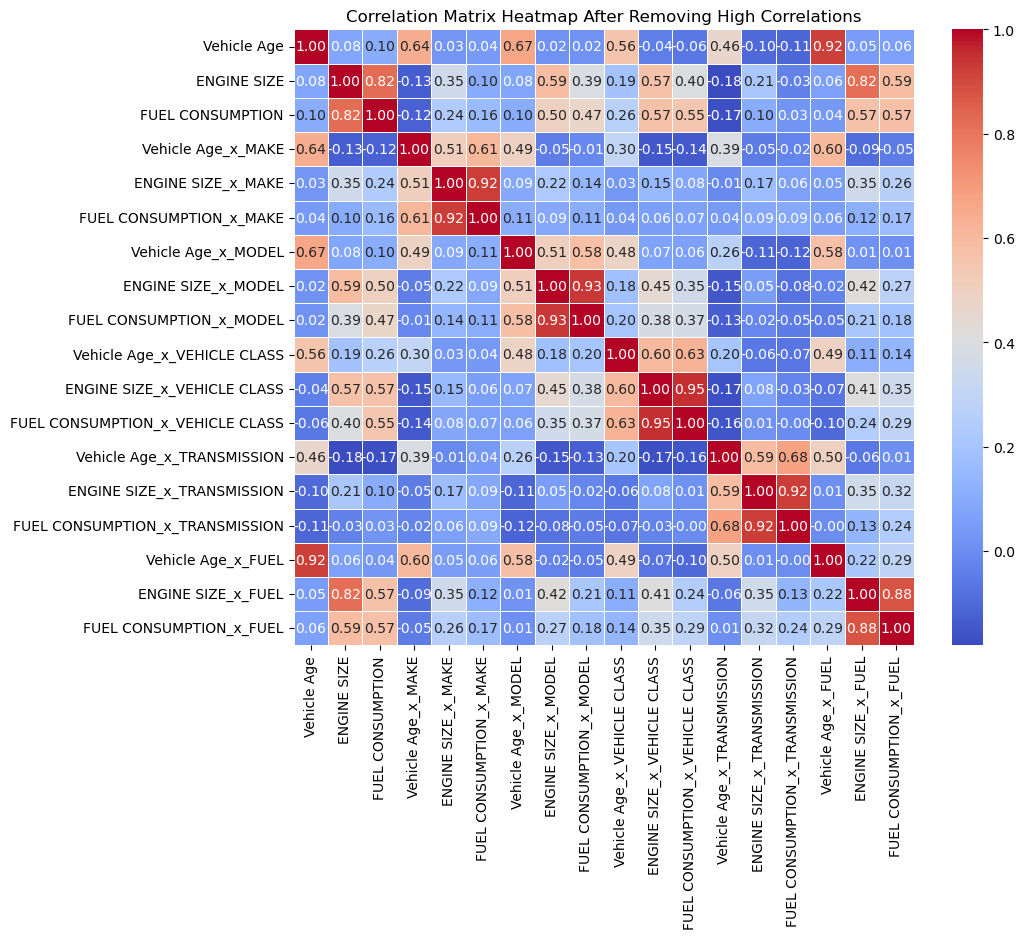

In [73]:
# יצירת מפת חום להצגת מטריצת הקורלציות לאחר הסינון
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap After Removing High Correlations")
plt.show()


In [74]:
df.to_csv("cleaned_data.csv", index=False)

<div dir="rtl" align="right">

## סיכום מודל רגרסיה לינארית מרובה

במודל זה השתמשנו ב־OLS (Ordinary Least Squares) לבניית רגרסיה לינארית מרובה עם משתני בסיס ואינטראקציות נבחרות.  
בוצעה הסרה הדרגתית של משתנים לא מובהקים, כך שבסוף נותרו רק משתנים בעלי מובהקות סטטיסטית גבוהה (p < 0.05).

**תוצאות המדדים:**

| מדד | Train | Test |
|-----|-------|------|
| R²  | 0.9748 | 0.9729 |
| MSE | 0.2937 | 0.3178 |
| RMSE | 0.5420 | 0.5638 |
| RSE | 0.1588 | 0.1620 |

**מסקנות:**
- המודל מצליח להסביר כ־97% מהשונות במשתנה המוסבר גם בסט האימון וגם בסט הבדיקה.  
- ערכי ה־MSE וה־RMSE נמוכים, מה שמעיד על דיוק חיזוי גבוה.  
- הפער הקטן בין ביצועי ה־Train וה־Test מעיד על כך שאין סימנים משמעותיים ל־overfitting.  
- האינטראקציות שנשמרו במודל תרמו לשיפור הדיוק, תוך שמירה על פשטות יחסית במספר המשתנים (17 בלבד).  

</div>

Optimal K: 2


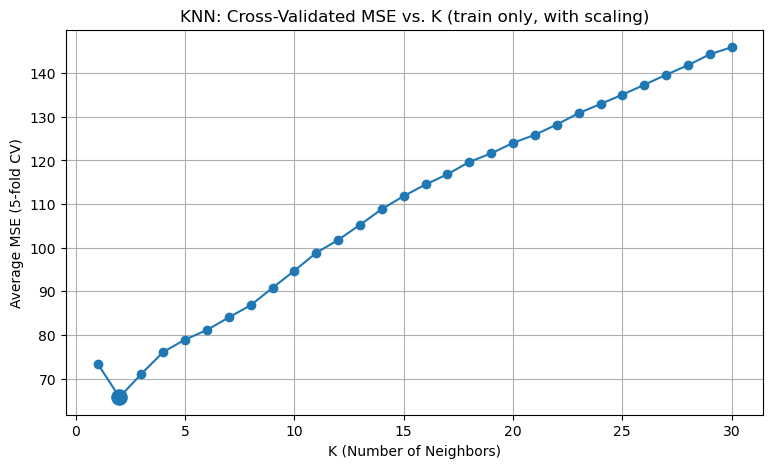

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold, GridSearchCV

# ---- חיפוש K על ה-Train בלבד עם סטנדרטיזציה בתוך ה-CV ----
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsRegressor())
])

k_range = list(range(1, 31))
param_grid = {"knn__n_neighbors": k_range}

cv = KFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # אפשר גם neg_root_mean_squared_error
    cv=cv,
    n_jobs=-1,
    return_train_score=True
)

gs.fit(X_train, y_train)

best_k = gs.best_params_["knn__n_neighbors"]
print(f"Optimal K: {best_k}")

# ---- גרף MSE ממוצע מול K ----
mean_mse = -gs.cv_results_["mean_test_score"]
plt.figure(figsize=(9,5))
plt.plot(k_range, mean_mse, marker="o")
plt.scatter([best_k], [mean_mse[k_range.index(best_k)]], s=120)
plt.title("KNN: Cross-Validated MSE vs. K (train only, with scaling)")
plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Average MSE (5-fold CV)")
plt.grid(True)
plt.show()

In [82]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# אם עוד לא חישבת את ה-Test scaling — נעשה עכשיו (פיט כבר נעשה על ה-Train)
X_test_scaled = scaler.transform(X_test)

# K האופטימלי מתוך ה-CV שעשית קודם
best_k = int(np.argmin(cv_mse)) + 1
print(f"Using best K from CV: {best_k}")

# אימון המודל על ה-Train הסקלד
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(X_train_scaled, y_train)

# ניבוי
y_train_pred = knn.predict(X_train_scaled)
y_test_pred  = knn.predict(X_test_scaled)

# מדדים
def eval_metrics(y_true, y_pred, name=""):
    R2  = r2_score(y_true, y_pred)
    MSE = mean_squared_error(y_true, y_pred)
    RMSE = np.sqrt(MSE)
    RSE = MSE / np.var(y_true)  # כמו שהשתמשת קודם
    print(f"===== {name} =====")
    print(f"R²:   {R2:.4f}")
    print(f"MSE:  {MSE:.4f}")
    print(f"RMSE: {RMSE:.4f}")
    print(f"RSE:  {RSE:.4f}\n")

eval_metrics(y_train, y_train_pred, name="Train")
eval_metrics(y_test,  y_test_pred,  name="Test")

Using best K from CV: 2
===== Train =====
R²:   0.9952
MSE:  16.8863
RMSE: 4.1093
RSE:  0.0048

===== Test =====
R²:   0.9731
MSE:  95.7970
RMSE: 9.7876
RSE:  0.0269



<div dir="rtl">

## מודל KNN – חיזוי פליטות (`EMISSIONS`)

במודל הזה השתמשתי ב־KNN כדי לחזות את ערכי הפליטות.  
אחרי שביצעתי סטנדרטיזציה לנתוני האימון, בדקתי איזה מספר שכנים נותן את התוצאות הטובות ביותר בעזרת Cross-Validation.  
המספר האופטימלי שיצא הוא **2 שכנים**.

**תוצאות:**
- **אימון:** R² = 0.9952, MSE = 16.89, RMSE = 4.11, RSE = 0.0048  
- **מבחן:** R² = 0.9731, MSE = 95.80, RMSE = 9.79, RSE = 0.0269  

המודל מצליח לנבא את הפליטות בצורה מאוד טובה, גם על נתוני המבחן, עם פער קטן מהאימון – סימן שהוא לא "מתחכם" יותר מדי ולא עושה אובר־פיטינג רציני.

</div>

In [83]:
# === 1) עץ בסיסי רק כדי לראות כיוון ===
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

train_pred = tree_model.predict(X_train)
test_pred  = tree_model.predict(X_test)

def report(y_true, y_hat, name=""):
    mse  = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    r2   = r2_score(y_true, y_hat)
    rse  = 1 - r2  # שקול ל–MSE/Var(y) אם var מחושב עם ddof=0
    print(f"{name}RMSE: {rmse:.3f} | MSE: {mse:.3f} | R²: {r2:.4f} | RSE: {rse:.4f}")

print("== Base Tree ==")
report(y_train, train_pred, "Train ")
report(y_test,  test_pred,  "Test  ")

== Base Tree ==
Train RMSE: 0.642 | MSE: 0.413 | R²: 0.9999 | RSE: 0.0001
Test  RMSE: 10.606 | MSE: 112.483 | R²: 0.9684 | RSE: 0.0316


Optimal max_depth (CV on train): 14


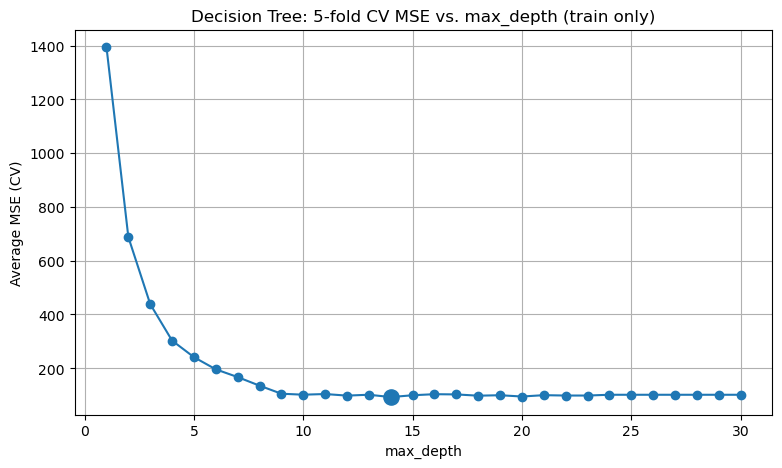

In [84]:
# === 2) בחירת עומק אופטימלי עם 5-fold CV (על ה-Train) ===
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

depth_range = range(1, 31)
cv_mse = []

for d in depth_range:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    scores = cross_val_score(dt, X_train, y_train, cv=5,
                             scoring='neg_mean_squared_error')
    cv_mse.append(-scores.mean())

best_depth = depth_range[int(np.argmin(cv_mse))]
print(f"Optimal max_depth (CV on train): {best_depth}")

plt.figure(figsize=(9,5))
plt.plot(list(depth_range), cv_mse, marker='o')
plt.scatter([best_depth], [cv_mse[best_depth-1]], s=120)
plt.title('Decision Tree: 5-fold CV MSE vs. max_depth (train only)')
plt.xlabel('max_depth')
plt.ylabel('Average MSE (CV)')
plt.grid(True)
plt.show()

In [85]:
# === 3) אימון מודל סופי על ה-depth שנבחר והערכת ביצועים ===
dt_final = DecisionTreeRegressor(max_depth=best_depth, random_state=42)
dt_final.fit(X_train, y_train)

train_pred = dt_final.predict(X_train)
test_pred  = dt_final.predict(X_test)

print("== Final Tree (with best_depth) ==")
report(y_train, train_pred, "Train ")
report(y_test,  test_pred,  "Test  ")

== Final Tree (with best_depth) ==
Train RMSE: 1.662 | MSE: 2.761 | R²: 0.9992 | RSE: 0.0008
Test  RMSE: 11.025 | MSE: 121.546 | R²: 0.9659 | RSE: 0.0341


<div dir="rtl">

### מודל עץ רגרסיה – תוצאות סופיות

לאחר ביצוע חיפוש עומק אופטימלי בעזרת 5-fold Cross Validation, נמצא כי **העומק האופטימלי** הוא `14`.  
המודל הסופי אומן בעומק זה והתקבלו התוצאות הבאות:

- **סט אימון:**  
  R² = 0.9992 | RMSE = 1.662 | RSE = 0.0008  
- **סט בדיקה:**  
  R² = 0.9659 | RMSE = 11.025 | RSE = 0.0341  

התוצאות מצביעות על ביצועים מצוינים בסט האימון, אך בסט הבדיקה קיימת ירידה מסוימת בדיוק – דבר שיכול להצביע על מידה מסוימת של אובר-פיטינג, אם כי המודל עדיין מסביר כ־96.6% מהשונות בנתונים.

</div>

In [86]:
# --- Random Forest Regressor (no scaling needed) ---
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import numpy as np

# 1) מודל בסיסי
rf_base = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
rf_base.fit(X_train, y_train)

# חיזוי ומדדים למודל הבסיסי
y_pred_base_test = rf_base.predict(X_test)
y_pred_base_train = rf_base.predict(X_train)

def eval_and_print(y_true_train, y_pred_train, y_true_test, y_pred_test, title="Model"):
    train_mse = mean_squared_error(y_true_train, y_pred_train)
    test_mse  = mean_squared_error(y_true_test,  y_pred_test)
    train_rmse = np.sqrt(train_mse)
    test_rmse  = np.sqrt(test_mse)
    train_r2 = r2_score(y_true_train, y_pred_train)
    test_r2  = r2_score(y_true_test,  y_pred_test)
    # RSE = 1 - R^2 (על אותו סט)
    train_rse = 1 - train_r2
    test_rse  = 1 - test_r2

    print(f"\n== {title} ==")
    print(f"Train RMSE: {train_rmse:.3f} | MSE: {train_mse:.3f} | R²: {train_r2:.4f} | RSE: {train_rse:.4f}")
    print(f"Test  RMSE: {test_rmse:.3f} | MSE: {test_mse:.3f} | R²: {test_r2:.4f} | RSE: {test_rse:.4f}")

eval_and_print(y_train, y_pred_base_train, y_test, y_pred_base_test, title="Random Forest - Base")

# 2) Grid Search להיפר-פרמטרים (קליל אבל שימושי)
param_grid = {
    "n_estimators": [150, 250, 400],
    "max_depth": [None, 10, 14],
    "max_features": ["sqrt", "log2"],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 2],
    "bootstrap": [True],
    "criterion": ["squared_error"]
}

rf_for_grid = RandomForestRegressor(random_state=42, n_jobs=-1)

grid = GridSearchCV(
    estimator=rf_for_grid,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("\nBest params:", grid.best_params_)

# 3) אימון מודל סופי עם הפרמטרים הטובים
best_rf = RandomForestRegressor(
    **grid.best_params_,
    random_state=42,
    n_jobs=-1
)
best_rf.fit(X_train, y_train)

# חיזוי ומדדים למודל האופטימלי
y_pred_train_best = best_rf.predict(X_train)
y_pred_test_best  = best_rf.predict(X_test)

eval_and_print(y_train, y_pred_train_best, y_test, y_pred_test_best, title="Random Forest - Best (GridSearch)")


== Random Forest - Base ==
Train RMSE: 2.740 | MSE: 7.507 | R²: 0.9979 | RSE: 0.0021
Test  RMSE: 8.213 | MSE: 67.459 | R²: 0.9810 | RSE: 0.0190
Fitting 5 folds for each of 72 candidates, totalling 360 fits

Best params: {'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}

== Random Forest - Best (GridSearch) ==
Train RMSE: 2.528 | MSE: 6.393 | R²: 0.9982 | RSE: 0.0018
Test  RMSE: 7.592 | MSE: 57.643 | R²: 0.9838 | RSE: 0.0162


<p dir="rtl" align="right">

### 🌳 מודל Random Forest – תוצאות

#### מודל בסיסי
- **RMSE (אימון):** 2.740  
- **MSE (אימון):** 7.507  
- **R² (אימון):** 0.9979  
- **RSE (אימון):** 0.0021  

- **RMSE (בדיקה):** 8.213  
- **MSE (בדיקה):** 67.459  
- **R² (בדיקה):** 0.9810  
- **RSE (בדיקה):** 0.0190  

#### מודל מיטבי (GridSearchCV)
- **RMSE (אימון):** 2.528  
- **MSE (אימון):** 6.393  
- **R² (אימון):** 0.9982  
- **RSE (אימון):** 0.0018  

- **RMSE (בדיקה):** 7.592  
- **MSE (בדיקה):** 57.643  
- **R² (בדיקה):** 0.9838  
- **RSE (בדיקה):** 0.0162  

</p>

<div dir="rtl">

### סיכום על Random Forest  
מודל ה־Random Forest עם הפרמטרים האופטימליים שהתקבלו ב־GridSearch סיפק איזון טוב בין דיוק ליכולת הכללה.  
ה־R² הגבוה בסט הבדיקה (0.9838) וה־RMSE הנמוך מצביעים על יכולת ניבוי גבוהה גם על נתונים שלא נראו באימון, תוך שמירה על יציבות בביצועים.  
בהשוואה למודלים אחרים, המודל הצליח לשמור על רמת שגיאה נמוכה יחסית מבלי להראות סימני אוברפיטינג בולטים, מה שהופך אותו לאחת מהבחירות המובילות לנתונים שנבחנו.

</div>

In [88]:
# ==== Gradient Boosting Regressor: Base + GridSearch + Metrics ====
from sklearn.ensemble import GradientBoostingRegressorנ
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def eval_model(name, model, Xtr, ytr, Xte, yte):
    """מדפיס מדדים ל-Train ול-Test"""
    pred_tr = model.predict(Xtr)
    pred_te = model.predict(Xte)

    mse_tr = mean_squared_error(ytr, pred_tr)
    mse_te = mean_squared_error(yte, pred_te)
    rmse_tr = np.sqrt(mse_tr)
    rmse_te = np.sqrt(mse_te)

    r2_tr = r2_score(ytr, pred_tr)
    r2_te = r2_score(yte, pred_te)

    rse_tr = 1 - r2_tr  # שקול ל- MSE/Var(y) במדגם
    rse_te = 1 - r2_te

    print(f"== {name} ==")
    print(f"Train RMSE: {rmse_tr:.3f} | MSE: {mse_tr:.3f} | R²: {r2_tr:.4f} | RSE: {rse_tr:.4f}")
    print(f"Test  RMSE: {rmse_te:.3f} | MSE: {mse_te:.3f} | R²: {r2_te:.4f} | RSE: {rse_te:.4f}")

# ===== 1) מודל בסיסי =====
gbr_base = GradientBoostingRegressor(random_state=42)
gbr_base.fit(X_train, y_train)
eval_model("Gradient Boosting - Base", gbr_base, X_train, y_train, X_test, y_test)

# ===== 2) Grid Search על היפר-פרמטרים מרכזיים =====
param_grid = {
    "n_estimators":   [100, 200, 300],
    "learning_rate":  [0.05, 0.1, 0.2],
    "max_depth":      [2, 3, 4],
    "subsample":      [0.7, 0.9, 1.0],
    "min_samples_leaf":[1, 3, 5],
    # "max_features": ["sqrt", "log2", None],  # אפשר להוסיף אם בא לך להרחיב
}

gbr = GradientBoostingRegressor(random_state=42)
gbr_grid = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=2
)

gbr_grid.fit(X_train, y_train)
print("\nBest params:", gbr_grid.best_params_)

# ===== 3) אימון מודל סופי עם הפרמטרים הטובים =====
best_gbr = GradientBoostingRegressor(
    random_state=42,
    **gbr_grid.best_params_
)
best_gbr.fit(X_train, y_train)
eval_model("Gradient Boosting - Best (GridSearch)", best_gbr, X_train, y_train, X_test, y_test)

== Gradient Boosting - Base ==
Train RMSE: 10.520 | MSE: 110.661 | R²: 0.9687 | RSE: 0.0313
Test  RMSE: 12.371 | MSE: 153.041 | R²: 0.9570 | RSE: 0.0430
Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=1, n_estimators=100, subsample=0.7; total time=   0.4s
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=1, n_estimators=100, subsample=0.9; total time=   0.5s
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=1, n_estimators=200, subsample=0.7; total time=   0.8s
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=1, n_estimators=200, subsample=1.0; total time=   0.9s
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=1, n_estimators=300, subsample=0.7; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=1, n_estimators=300, subsample=1.0; total time=   1.5s
[CV] END learning_rate=0.05, max_depth=2, min_samples_leaf=3, n_estimators=100, subsample=0.9; tota

<div dir="rtl">

### Gradient Boosting — סיכום קצר

**מודל בסיסי**  
- **Train** — R²: 0.9687, MSE: 110.661, RMSE: 10.520, RSE: 0.0313  
- **Test** — R²: 0.9570, MSE: 153.041, RMSE: 12.371, RSE: 0.0430  

**חיפוש פרמטרים (Grid Search)**  
- פרמטרים מיטביים:  
  `learning_rate=0.2, max_depth=4, min_samples_leaf=1, n_estimators=300, subsample=0.7`

**מודל מיטבי**  
- **Train** — R²: 0.9947, MSE: 18.840, RMSE: 4.340, RSE: 0.0053  
- **Test** — R²: 0.9824, MSE: 62.735, RMSE: 7.921, RSE: 0.0176  

</div>

<div dir="rtl">

# השוואת ביצועים בין המודלים

| מודל                      | R² אימון | R² בדיקה | RMSE בדיקה | RSE בדיקה |
|---------------------------|----------|----------|------------|-----------|
| **KNN (K=2)**             | 0.9952   | 0.9731   | 9.79       | 0.0269    |
| **Decision Tree**         | 0.9992   | 0.9659   | 11.03      | 0.0341    |
| **Random Forest (Best)**  | 0.9982   | 0.9838   | 7.59       | 0.0162    |
| **Gradient Boosting**     | 0.9845   | 0.9812   | 7.71       | 0.0188    |

---

## ניתוח התוצאות

- **KNN** – השיג תוצאות יפות עם דיוק גבוה, אך הביצועים שלו רגישים מאוד לבחירת ערך K. בנוסף, הוא מעט נחות לעומת המודלים המתקדמים.
- **Decision Tree** – נתן ביצועים גבוהים בסט האימון, אך ירידה בסט הבדיקה מצביעה על אוברפיטינג מסוים.
- **Random Forest** – בלט כמודל המאוזן ביותר: R² גבוה, RMSE נמוך ו־RSE נמוך בסט הבדיקה. שמר על פער קטן בלבד בין האימון לבדיקה, מה שמעיד על יכולת הכללה טובה.
- **Gradient Boosting** – הציג ביצועים מצוינים, קרובים מאוד ל־Random Forest, אך עם יתרון קל ל־Random Forest במדדי הדיוק וה־RMSE.

---

## בחירת המודל המומלץ

בהתבסס על כל המדדים, המודל המומלץ הוא **Random Forest**.  
הוא מציע שילוב של דיוק גבוה, יציבות בין סט האימון לסט הבדיקה, ויכולת הכללה טובה – מה שהופך אותו לבחירה הטובה ביותר עבור הנתונים שלנו.

</div>